In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from function_file import clean_names
import seaborn as sns


C:\Users\K\AppData\Local\Temp\ipykernel_9792\2295007993.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
raw_candy_15 = pd.read_excel(r"data_in\boing-boing-candy-2015.xlsx")
raw_candy_16 = pd.read_excel(r"data_in\boing-boing-candy-2016.xlsx")
raw_candy_17 = pd.read_excel(r"data_in\boing-boing-candy-2017.xlsx")

C:\Users\K\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
# raw_candy_16.columns
# raw_candy_17.columns

In [4]:
candy_15 = raw_candy_15.drop(['Timestamp'],axis = 1).copy()

# Create core Columns required for this analysis
candy_15["country"] = np.nan
candy_15["gender"] = ""
candy_15["year"] = "2015"

#Create Alias for unique entry
candy_15["id"] = candy_15["year"]+"_"+candy_15.reset_index().index.astype('string')

# Rename Age column for consistency
candy_15_col_name= {'Are you going actually going trick or treating yourself?':'go_out',
    'How old are you?':'age'}
candy_15.rename(columns = candy_15_col_name, inplace = True)


#This is the pivot long equalvalent
piv_candy_15 = candy_15.melt(id_vars = ['id','age', 'go_out', 'country', 'gender','year'])


In [5]:
# Drop columns
candy_16 = raw_candy_16.drop(['Timestamp', 'Which state, province, county do you live in?'],axis = 1).copy()

# Create Year Column
candy_16["year"] = "2016"

#Create Alias for unique entry
candy_16["id"] = candy_16["year"]+"_"+candy_16.reset_index().index.astype('string')

candy_16_col_name= {'Are you going actually going trick or treating yourself?':'go_out',
                    'How old are you?':'age',
                    'Which country do you live in?': 'country',
                    'Your gender:':'gender'}

candy_16.rename(columns = candy_16_col_name, inplace = True)

#This is the pivot long equalvalent
piv_candy_16 = candy_16.melt(id_vars = ['id','year', 'age', 'country', 'gender','go_out'])


In [6]:
# Drop columns
candy_17 = raw_candy_17.drop(['Internal ID', 'Q5: STATE, PROVINCE, COUNTY, ETC', 'Click Coordinates (x, y)'],axis = 1).copy()

# Create Year Column
candy_17["year"] = "2017"

#Create Alias for unique entry
candy_17["id"] = candy_17["year"]+"_"+candy_17.reset_index().index.astype('string')

# Rename core columns (gender, age, country)
candy_17_col_name = {'Q2: GENDER': "gender",
                     'Q3: AGE':"age",
                     'Q4: COUNTRY':"country",
                     'Q1: GOING OUT?':'go_out'}
candy_17.rename(columns=candy_17_col_name, inplace = True)



#Drop column with ':' (none candy columns)
candy_17.drop(candy_17.filter(regex=':').columns, axis=1, inplace=True)

#Remove "Q1 | " pattern for all column names
candy_17.rename(columns=lambda x: re.sub('([Qq].*? \\| )','',x), inplace=True)

piv_candy_17 = candy_17.melt(id_vars = ['id','year', 'age', 'country', 'gender','go_out'])

In [7]:
# Bind dataframes for 2015,2016,2017
df_piv = pd.concat([piv_candy_15, piv_candy_16, piv_candy_17])

In [8]:
clean_country = df_piv.copy()

clean_country["country"] = clean_country["country"].str.upper()

#Remove brackets and whats inside
clean_country["country"] = clean_country["country"].str.replace(r'\(.*?\)', '', regex=True)
#Replace United states of mareican with USA


# clean_country["country"] = clean_country["country"].str.extract(r'(U.*S.*A)', 'USA')

clean_country.loc[clean_country["country"].str.contains('(U.*S)', na=False), 'country'] = "USA"

clean_country["country"] = clean_country["country"].str.replace(r'[^A-Za-z]', '', regex=True).str.strip()

# Remove any country that has more than 12 letter (i.e. longest string)
clean_country.loc[clean_country["country"].str.contains('[A-Z]{12,}', na=False), 'country'] = ""

clean_country["country"] = clean_country["country"].astype("category")
clean_country["go_out"] = clean_country["go_out"].astype("category")

C:\Users\K\AppData\Local\Temp\ipykernel_9792\2375883885.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean_country.loc[clean_country["country"].str.contains('(U.*S)', na=False), 'country'] = "USA"


In [9]:
clean_age = clean_country.copy()

clean_age.loc[clean_age["age"].str.contains('[^0-9]', na=False), 'age'] = np.nan

clean_age["age"] = clean_age["age"].astype('float')

# Remove any age bigger than 99
clean_age.loc[clean_age["age"]>99, 'age'] = np.nan

In [10]:
clean_sweet = clean_age.copy()
clean_sweet["variable"] = clean_sweet["variable"].str.strip()
clean_sweet = clean_sweet.loc[clean_sweet["variable"].str.count(" ")<=5]
clean_sweet = clean_sweet.loc[~clean_sweet["variable"].str.contains("Ignore")]


In [11]:
clean_sweet["id"].value_counts()

id
2017_2459    97
2017_2452    97
2017_1231    97
2017_2458    97
2017_2457    97
             ..
2015_1886    91
2015_1885    91
2015_1884    91
2015_1890    91
2015_4674    91
Name: count, Length: 9349, dtype: Int64

In [12]:
avg_age = clean_sweet[['id','year', 'age', 'country', 'gender','go_out']].copy()
avg_age = avg_age.drop_duplicates().dropna(subset = "age")
avg_age["go_out"] = avg_age["go_out"].astype("category")

Text(0.5, 1.0, 'Boxplot')

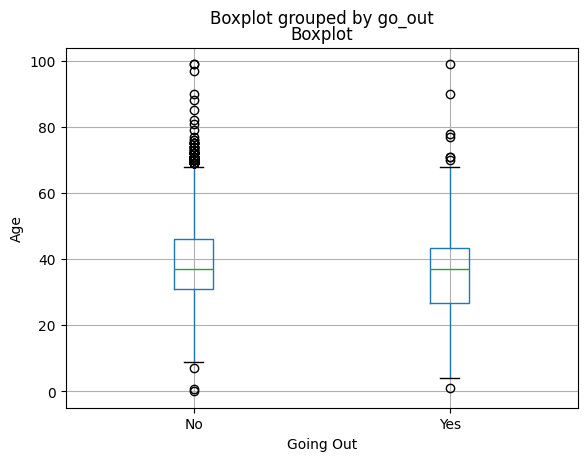

In [13]:
plt.show()
boxplot = avg_age.boxplot(column='age', by = 'go_out')
boxplot.set_ylabel("Age")
boxplot.set_xlabel("Going Out")
boxplot.set_title("Boxplot")

<Axes: xlabel='age', ylabel='Density'>

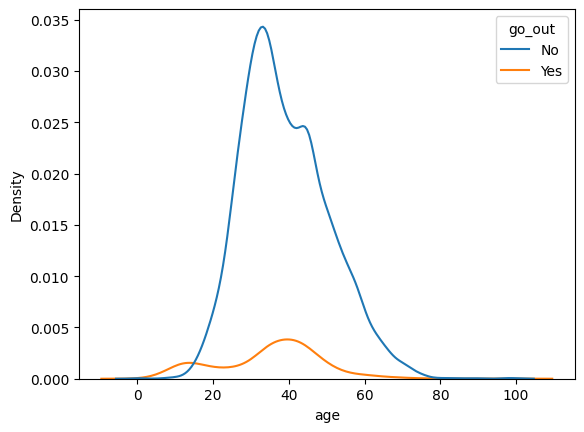

In [14]:
plt.show()
sns.kdeplot(data = avg_age, x = "age", hue = "go_out")

In [15]:
# What was the average age of people who are going out trick or treating?
# What was the average age of people who are not going trick or treating?

avg_age_go_out= avg_age.groupby(["go_out"])["age"].mean()
avg_age_go_out

C:\Users\K\AppData\Local\Temp\ipykernel_9792\468201356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_age_go_out= avg_age.groupby(["go_out"])["age"].mean()


go_out
No     39.104911
Yes    34.941489
Name: age, dtype: float64

In [16]:
# What is the total number of candy ratings given across the three years. (Number of candy ratings, not the number of raters. Don’t count missing values)
tot_num = clean_sweet.copy()
tot_num["value"] = tot_num["value"].str.upper().str.strip()
tot_num = tot_num.loc[tot_num["value"].isin(['MEH', 'DESPAIR','JOY'])]
tot_num.shape[0]



724572

In [17]:
# For each of joy, despair and meh, which candy bar revived the most of these ratings?
df_candy = tot_num.copy()
df_candy["variable"] = df_candy["variable"].str.replace(r'[^0-9A-Za-z\s]', '', regex=True).str.strip().str.upper()

df_candy_rating_n = (df_candy.groupby(["variable"])["variable"].count().reset_index(name = "count").sort_values(["count"], ascending = False).head(1))
df_candy_rating_n

,variable,count
82,REESES PEANUT BUTTER CUPS,8386


In [18]:
df_candy_starburst = df_candy.copy()

df_candy_starburst = df_candy_starburst.loc[(df_candy_starburst["variable"]== "STARBURST") & (df_candy_starburst["value"]=="DESPAIR")]
df_candy_starburst.groupby(["variable", "value"])["value"].count().reset_index(name = "count")

# How many people rated Starburst as despair?



,variable,value,count
0,STARBURST,DESPAIR,1990


In [19]:
# Assign Rating to Values
    
df_candy_rating = df_candy.copy()
# df_candy_rating["rating"] = df_candy_rating.apply(assign_rating, axis=1)

df_candy_rating["rating"]= np.where(df_candy_rating.value == 'JOY', 1, 
                                    np.where(df_candy_rating.value == 'DESPAIR', -1, 0))

# Excluding Any Fullsize Candy bar since we are doing specific candy analysis
df_candy_rating = df_candy_rating.loc[df_candy_rating["variable"]!="ANY FULLSIZED CANDY BAR"]


In [20]:
# What was the most popular candy bar by this rating system for each gender in the dataset ?
df_gender_rating = df_candy_rating.copy()
df_gender_rating = df_candy_rating.groupby(["gender", "variable"])["rating"].sum().reset_index(name = "final_rating")
df_gender_rating = df_gender_rating.loc[df_gender_rating.groupby(["gender"])["final_rating"].idxmax()]
df_gender_rating

,gender,variable,final_rating
64,,REESES PEANUT BUTTER CUPS,4375
156,Female,REESES PEANUT BUTTER CUPS,768
228,I'd rather not say,KIT KAT,62
352,Male,REESES PEANUT BUTTER CUPS,1443
474,Other,TWIX,32


In [21]:
# What was the most popular candy bar in each year?
df_year_rating = df_candy_rating.copy()
df_year_rating = df_year_rating.groupby(["year", "variable"])["rating"].sum().reset_index(name = "tot_rating")

find_max = df_year_rating.groupby(["year"])["tot_rating"].idxmax()

df_year_rating.loc[find_max]


,year,variable,tot_rating
64,2015,REESES PEANUT BUTTER CUPS,4375
127,2016,KIT KAT,920
248,2017,REESES PEANUT BUTTER CUPS,1403


In [25]:
# What was the most popular candy bar by this rating for people in US, Canada, UK, and all other countries?
df_country_rating = df_candy_rating.copy()

list_us = ["USA", "MURICA" "AAMERICA", "USA", "USSA", "AMERICA",  "AHEMAMERCA"]
list_uk = ["UK"]
list_can = ["CAN", "CANADA"]

df_country_rating["country_cat"] = np.where(df_country_rating["country"].isin(list_us), "US", 
                                          np.where(df_country_rating["country"].isin(list_uk), "UK",
                                                   np.where(df_country_rating["country"].isin(list_can), "CANADA", "OTHER")))

df_country_rating = df_country_rating.groupby(["country_cat", "variable"])["rating"].sum().reset_index(name = "tot_rating")

country_find_max = df_country_rating.groupby(["country_cat"])["tot_rating"].idxmax()

df_country_rating.loc[country_find_max]

,country_cat,variable,tot_rating
42,CANADA,KIT KAT,230
179,OTHER,REESES PEANUT BUTTER CUPS,4485
259,UK,LINDT TRUFFLE,17
378,US,REESES PEANUT BUTTER CUPS,1976
